In [0]:
%tensorflow_version 2.x
import numpy as np
from google.colab import drive
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Flatten,Activation,Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,concatenate,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import cv2
%matplotlib inline

In [0]:
drive.mount('/gdrive')
# Розпаковка датасета з гуглдиска на віртуальну машину
! unzip -o "/gdrive/My Drive/Colab Notebooks/overlay/dataset_overlay_new.zip" >>r.txt

In [0]:
def show_history(his1, his2, name):
  """
  Будує графіки
  """
  plt.plot(his1, label=name+' на навчальному наборі')
  plt.plot(his2, label=name+' на перевірочному наборі')
  plt.xlabel('Епоха')
  plt.ylabel(name)
  plt.legend()
  plt.show() 

In [0]:
def Сlassifier_model(weights,load_all_weights=False, input_shape=(150,150,3), classes = 4):
    """
    Класифікатор зображень з classes класами
     # Аргументи
        weights: вагові коефіцієнти мережі  
        load_all_weights: вказує на потребу завантаження всіх коефіцієнтів мережі,
                          при False лише CNN частини мережі отримані при навчанні 
                          на наборі ImageNet для VGG16
        input_shape: форма зображення
        classes: кількість класів 
    
    """
    
    model = Sequential()
    # Блок 1
    model.add(Conv2D(64, (3, 3),activation='relu',padding='same',name='block1_conv1',input_shape=input_shape))
    model.add(Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))
    # Блок 2
    model.add(Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1'))
    model.add(Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))
    
    # Блок 3
    model.add(Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1'))
    model.add(Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2'))
    model.add(Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))
    
    # Блок 4
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))
     # Блок 5
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))
    
    # Завантаження вагових коефіцієнтів для CNN частини та заборона їх зміни
    if not load_all_weights:
      model.load_weights(weights)
      for layer in model.layers:
        layer.trainable = False

    # Блок класифікації
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(classes))
    model.add(Activation('softmax'))
    
    if load_all_weights:
      model.load_weights(weights)
       
    return model

In [0]:
# Каталогі
train_dir = 'dataset_overlay_new/train'
test_dir = 'dataset_overlay_new/test'
val_dir = 'dataset_overlay_new/val'
# Размір та форма зображення
img_width, img_height = 160, 160
input_shape = (img_width, img_height, 3)
step = 2
class_count = 7
batch_size = 32
nb_train_samples = class_count*1880
nb_validation_samples = class_count*500
nb_test_samples = class_count*500

In [0]:
model = Сlassifier_model(weights='/gdrive/My Drive/Colab Notebooks/models/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',input_shape=input_shape,classes=class_count)
# model.summary()

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

In [0]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                            zoom_range=0.2,
                            fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)# обовязково shuffle=False для нормальної побудови матриці помилок

In [0]:
print(train_generator.class_indices)

In [0]:
callbacks = []
callbacks.append(EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto'))

In [0]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=step*nb_train_samples // batch_size,
    epochs= 13,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=callbacks
)

In [0]:
print("Навчання зупинено на ", callbacks[0].stopped_epoch)
scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)
print("Точність на тестових данних: %.2f%%" % (scores[1]*100))

In [0]:
model.save('/gdrive/My Drive/Colab Notebooks/overlay/find_overlay160x160_4.h5')

In [0]:
# Донавчання останніго 5-го блоку CNN частини мережі
model.trainable = True
trainable = False
for layer in model.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable
# model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

history2 = model.fit_generator(
    train_generator,
    steps_per_epoch=step*nb_train_samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size, callbacks=callbacks)


scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)
print("Точність на тестових данних: %.2f%%" % (scores[1]*100))

# import datetime
# file_model ="Сlassifier_model_por"+str(datetime.date.today())
# save_model(file_model,"/gdrive/My Drive/Colab Notebooks/models/best/") 

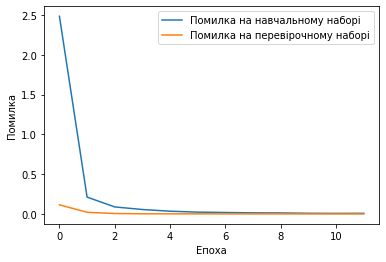

In [0]:
show_history(history.history['accuracy'], history.history['val_accuracy'],'Точність')
show_history(history.history['loss'], history.history['val_loss'],'Помилка')
